# Evaluation of different classification algorithms for COVID-19 Pandemic Tweets

#### Stylianos Sidiropoulos (stysi607)

#### Text Mining (732A92) - Linköping University

## Load Libraries

In [1]:
import pandas as pd
import numpy as np
import spacy
import matplotlib.pyplot as plt
from collections import Counter
from wordcloud import WordCloud

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, plot_confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow.keras.layers as L
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam

## Data Preprocessing

In [2]:
# Read data and merge it into one dataset
data = pd.read_csv("https://raw.githubusercontent.com/steliossid/covid19-classification/main/data.csv", encoding="latin")

not_whole_dataset = False
if not_whole_dataset:
    data = data.loc[:1000]
data.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [3]:
# Keep only OriginalTweet and Sentiment columns
data.pop("UserName")
data.pop("ScreenName")
data.pop("Location")
data.pop("TweetAt")
data.head()

,OriginalTweet,Sentiment
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,advice Talk to your neighbours family to excha...,Positive
2,Coronavirus Australia: Woolworths to give elde...,Positive
3,My food stock is not the only one which is emp...,Positive
4,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [4]:
data.shape

(44955, 2)

In [5]:
# Check if there are null values
data.isnull().values.any()

False

In [6]:
# Classes
sentiments = data.Sentiment.unique().tolist()
sentiments

['Neutral', 'Positive', 'Extremely Negative', 'Negative', 'Extremely Positive']

### Balance Dataset

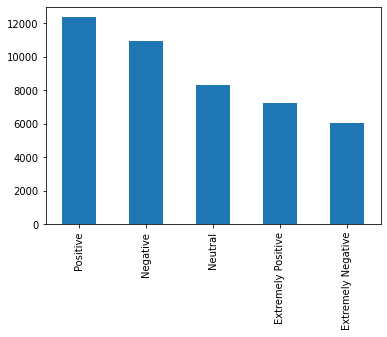

In [7]:
data.Sentiment.value_counts().plot(kind='bar');

In [8]:
data.Sentiment.value_counts()

Positive              12369
Negative              10958
Neutral                8332
Extremely Positive     7223
Extremely Negative     6073
Name: Sentiment, dtype: int64

Dataset is not balanced.

In [9]:
# Balance dataset
count_min = data.Sentiment.value_counts().min()

# Divide by class and Random undersampling without replacement
df_Pos = data[data.Sentiment == "Positive"].sample(count_min)
df_Neg = data[data.Sentiment == "Negative"].sample(count_min)
df_Neu = data[data.Sentiment == "Neutral"].sample(count_min)
df_ExPos = data[data.Sentiment == "Extremely Positive"].sample(count_min)
df_ExNeg = data[data.Sentiment == "Extremely Negative"]

data_balanced = pd.concat([df_Pos, df_Neg, df_Neu, df_ExPos, df_ExNeg], axis=0)

In [10]:
data_balanced.Sentiment.value_counts()

Extremely Negative    6073
Positive              6073
Extremely Positive    6073
Negative              6073
Neutral               6073
Name: Sentiment, dtype: int64

### Natural Language Processing (NLP)

In [11]:
nlp = spacy.load('en_core_web_sm', disable=['parser', 'tagger', 'ner'])

def preprocess(text):
  # lowercase all words
  # discard stopwords
  # discard non-alphabetic characters like numbers, http links, hashtags, mentions etc.
  # discard tokens with less than 3 characters
  # discard words in words2remove
  # return word lemma
  doc = nlp(text)
  words2remove = ["coronavirus", "coronaviru", "covid19", "covid-19", "covid", "amp"]
  return [token.lemma_.lower() for token in doc if not token.is_stop and token.lemma_.isalpha() and len(token)>2 and token.lemma_.lower() not in words2remove]

In [12]:
data_balanced["ProcessedTweet"] = data_balanced["OriginalTweet"].apply(lambda x: ' '.join(preprocess(x)))
data_balanced.head()

,OriginalTweet,Sentiment,ProcessedTweet
39460,Bernie s Emergency Health Care Guarantee Act w...,Positive,bernie emergency health care guarantee act req...
36553,#coronavirus How to Save Money When Grocery Sh...,Positive,save money grocery shopping online clark howard
8385,#Coronavirus: Asian woman dragged out of a sup...,Positive,asian woman drag supermarket ghana refuse use ...
44264,"""Donald Trump reportedly tried to poach German...",Positive,donald trump reportedly try poach german scien...
13934,After I spent 30 minutes on queue sanitizing m...,Positive,spend minute queue sanitize entrance realize s...


Some rows are empty after text processing, so we exclude them.

In [13]:
is_empty = data_balanced.ProcessedTweet==""
data_balanced = data_balanced[is_empty==False]

There are minor changes in the balance of the classes, so there is no need to rebalance the classes

In [14]:
data_balanced.Sentiment.value_counts()

Extremely Negative    6073
Extremely Positive    6073
Positive              6072
Negative              6072
Neutral               6040
Name: Sentiment, dtype: int64

In [15]:
data = data_balanced.copy()
data.shape

(30330, 3)

## Statistics

### Number of words in tweet

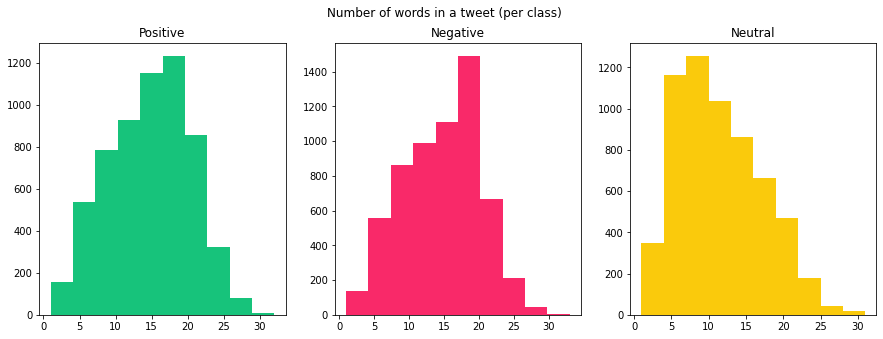

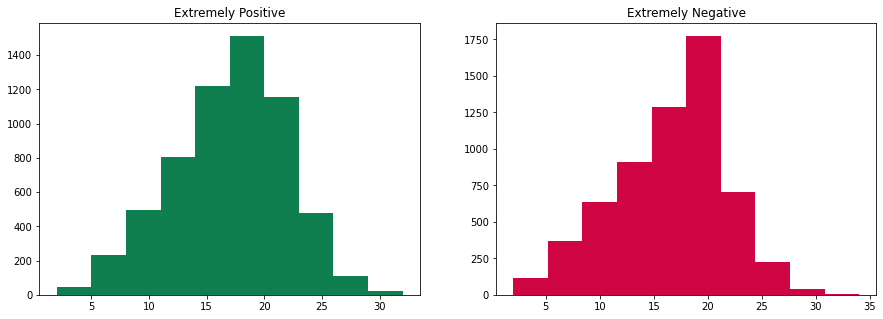

In [16]:
fig1,(ax1,ax2,ax3)=plt.subplots(1,3,figsize=(15,5))
fig2,(ax4, ax5)=plt.subplots(1,2,figsize=(15,5))

len_pos = data[data['Sentiment']=="Positive"]['ProcessedTweet'].str.split().map(lambda x: len(x))
ax1.hist(len_pos, color='#17C37B')
ax1.set_title('Positive')

len_neg = data[data['Sentiment']=="Negative"]['ProcessedTweet'].str.split().map(lambda x: len(x))
ax2.hist(len_neg, color='#F92969')
ax2.set_title('Negative')

len_neu = data[data['Sentiment']=="Neutral"]['ProcessedTweet'].str.split().map(lambda x: len(x))
ax3.hist(len_neu, color='#FACA0C')
ax3.set_title('Neutral')

len_expos = data[data['Sentiment']=="Extremely Positive"]['ProcessedTweet'].str.split().map(lambda x: len(x))
ax4.hist(len_expos, color='#0f7f50')
ax4.set_title('Extremely Positive')

len_exneg = data[data['Sentiment']=="Extremely Negative"]['ProcessedTweet'].str.split().map(lambda x: len(x))
ax5.hist(len_exneg, color='#d00644')
ax5.set_title('Extremely Negative')

fig1.suptitle('Number of words in a tweet (per class)')
plt.show()

### Wordclouds

In [17]:
def create_wordlist(sentiment):
    wordlist=[]
    
    if sentiment == "whole_dataset":
      proc_tweet = data["ProcessedTweet"].str.split()
    else:
      proc_tweet = data[data["Sentiment"]==sentiment]["ProcessedTweet"].str.split()
    for line in proc_tweet:
        for word in line:
          wordlist.append(word)
    return wordlist

def create_wordcloud(sentiment):
    wordcloud = WordCloud().generate(" ".join(words for words in create_wordlist(sentiment)))
    plt.imshow(wordcloud)
    plt.axis("off")
    if sentiment=="whole_dataset":
      plt.title("Whole dataset wordcloud")
    else:
      plt.title(sentiment + " " + "wordcloud")
    plt.show()

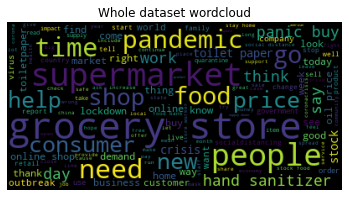

In [18]:
create_wordcloud("whole_dataset")

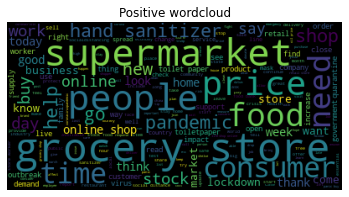

In [19]:
create_wordcloud("Positive")

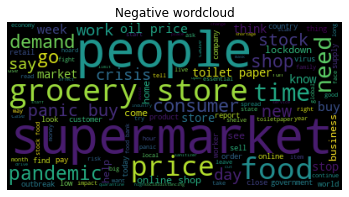

In [20]:
create_wordcloud("Negative")

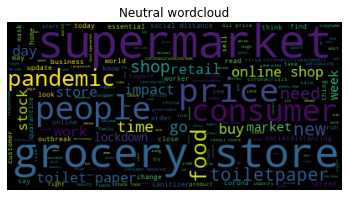

In [21]:
create_wordcloud("Neutral")

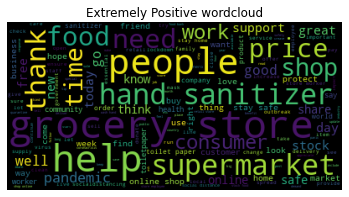

In [22]:
create_wordcloud("Extremely Positive")

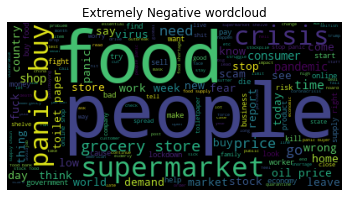

In [23]:
create_wordcloud("Extremely Negative")

In [24]:
def most_common_ngrams(sentiment, n_gram=1, n_common=10):
    wordlist = create_wordlist(sentiment)
    ngrams = zip(*[wordlist[i:] for i in range(n_gram)])
    counter = Counter(' '.join(ngram) for ngram in ngrams)

    most_common = counter.most_common(n_common)
    count = [word[0] for word in most_common][::-1]
    words = [word[1] for word in most_common][::-1]
    plt.barh(count, words)
    plt.title(sentiment)
    plt.show()

### Uni-grams

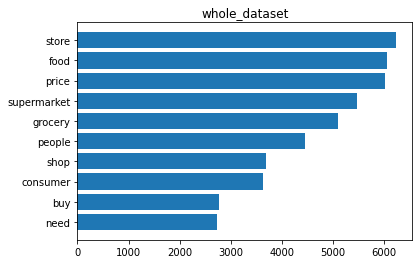

In [25]:


most_common_ngrams("whole_dataset")

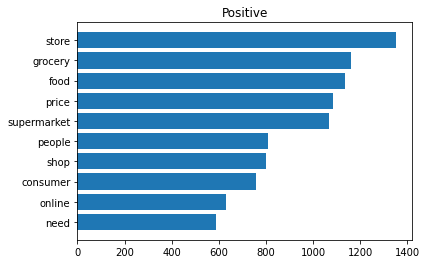

In [26]:
most_common_ngrams("Positive")

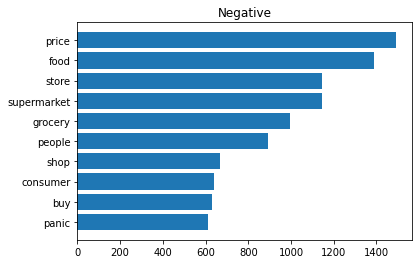

In [27]:
most_common_ngrams("Negative")

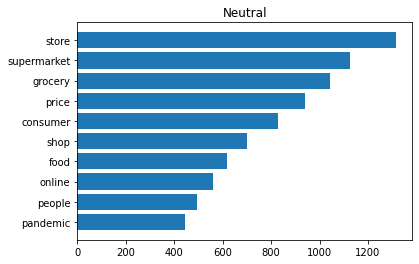

In [28]:
most_common_ngrams("Neutral")

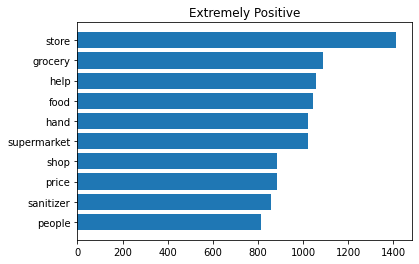

In [29]:
most_common_ngrams("Extremely Positive")

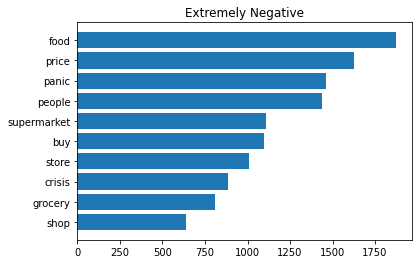

In [30]:
most_common_ngrams("Extremely Negative")

### Bi-grams

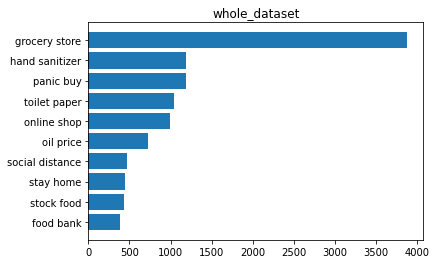

In [31]:
most_common_ngrams("whole_dataset", n_gram=2)

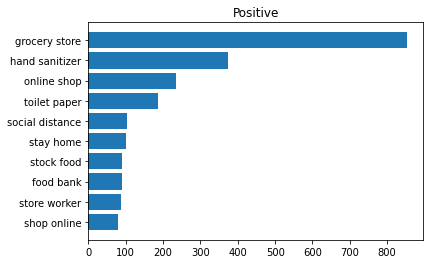

In [32]:
most_common_ngrams("Positive", n_gram=2)

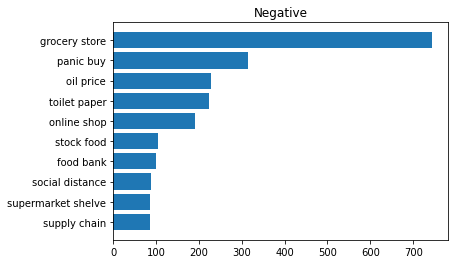

In [33]:
most_common_ngrams("Negative", n_gram=2)

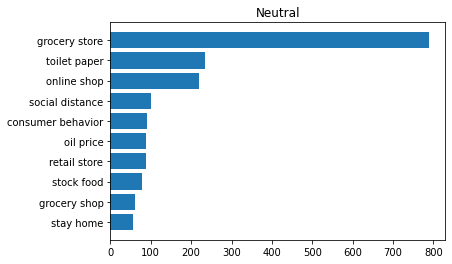

In [34]:
most_common_ngrams("Neutral", n_gram=2)

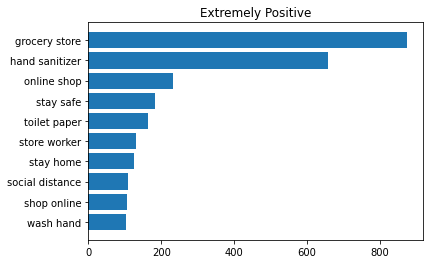

In [35]:
most_common_ngrams("Extremely Positive", n_gram=2)

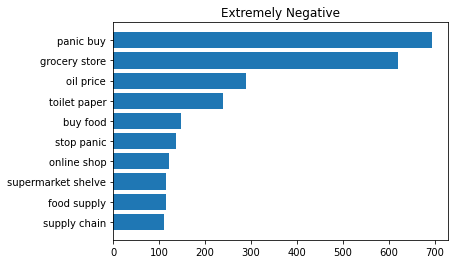

In [36]:
most_common_ngrams("Extremely Negative", n_gram=2)

## Models

In [37]:
# Split train, test
X = data.ProcessedTweet
y = data.Sentiment
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0)

# Vectorizer
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2), min_df=3, max_df=0.9)
count_vectorizer = CountVectorizer(ngram_range=(1, 2), min_df=3, max_df=0.9)

def print_results(model):
  model.fit(X_train, y_train)
  y_predicted = model.predict(X_test)
  print(classification_report(y_test, y_predicted))

### Multinomial Naive Bayes

In [38]:
# Find optimal parameters
model = Pipeline([
    ('vectorizer', count_vectorizer),
    ('predictor', MultinomialNB())
])

parameters = {
    "predictor__alpha": (0.1, 1)
}

grid_search = GridSearchCV(model, parameters, cv=5, n_jobs=-1)
grid_search = grid_search.fit(X_train, y_train)

#print("Grid Search Best Score: " + str(grid_search.best_score_))

for param_name in sorted(parameters.keys()):
    print("%s: %r" % (param_name, grid_search.best_params_[param_name]))
    
# Using optimal parameters
model = Pipeline([
    ('vectorizer', tfidf_vectorizer),
    ('predictor', MultinomialNB(alpha=grid_search.best_params_["predictor__alpha"]))
])

print_results(model)

predictor__alpha: 1
                    precision    recall  f1-score   support

Extremely Negative       0.58      0.71      0.64      1211
Extremely Positive       0.54      0.68      0.60      1225
          Negative       0.34      0.29      0.31      1199
           Neutral       0.62      0.49      0.55      1239
          Positive       0.35      0.30      0.32      1192

          accuracy                           0.50      6066
         macro avg       0.48      0.49      0.48      6066
      weighted avg       0.49      0.50      0.49      6066



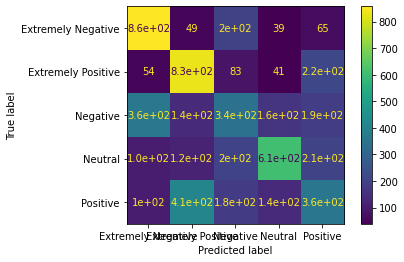

In [39]:
plot_confusion_matrix(model, X_test, y_test)

### Logistic Regression

In [40]:
# Find optimal parameters
model = Pipeline([
    ('vectorizer', tfidf_vectorizer),
    ('predictor', LogisticRegression(max_iter=10000))
])

parameters = {
    "predictor__C": (1,3,5),
    "predictor__penalty": ("l1", "l2")
}

grid_search = GridSearchCV(model, parameters, cv=5, n_jobs=-1)
grid_search = grid_search.fit(X_train, y_train)

#print("Grid Search Best Score: " + str(grid_search.best_score_))

for param_name in sorted(parameters.keys()):
    print("%s: %r" % (param_name, grid_search.best_params_[param_name]))
    
# Using optimal parameters
model = Pipeline([
    ('vectorizer', tfidf_vectorizer),
    ('predictor', LogisticRegression(penalty=grid_search.best_params_["predictor__penalty"],
                                     C=grid_search.best_params_["predictor__C"],
                                     max_iter=10000))
])

print_results(model)

predictor__C: 3
predictor__penalty: 'l2'
                    precision    recall  f1-score   support

Extremely Negative       0.69      0.74      0.71      1211
Extremely Positive       0.67      0.73      0.70      1225
          Negative       0.43      0.37      0.40      1199
           Neutral       0.63      0.72      0.68      1239
          Positive       0.45      0.38      0.41      1192

          accuracy                           0.59      6066
         macro avg       0.58      0.59      0.58      6066
      weighted avg       0.58      0.59      0.58      6066



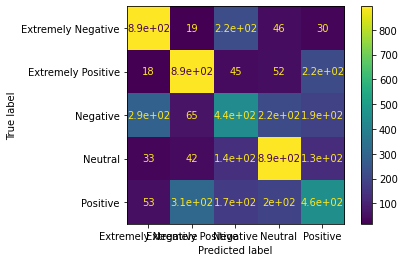

In [41]:
plot_confusion_matrix(model, X_test, y_test)

### Random Forest Classifier

In [42]:
# Find optimal parameters
model = Pipeline([
    ('vectorizer', tfidf_vectorizer),
    ('predictor', RandomForestClassifier())
])

parameters = {
    "predictor__max_depth": (1,5,10,50),
    "predictor__n_estimators": (5,10,100,500)
}

grid_search = GridSearchCV(model, parameters, cv=5, n_jobs=-1)
grid_search = grid_search.fit(X_train, y_train)

#print("Grid Search Best Score: " + str(grid_search.best_score_))

for param_name in sorted(parameters.keys()):
    print("%s: %r" % (param_name, grid_search.best_params_[param_name]))
    
# Using optimal parameters
model = Pipeline([
    ('vectorizer', tfidf_vectorizer),
    ('predictor', RandomForestClassifier(max_depth=grid_search.best_params_["predictor__max_depth"], 
                                         n_estimators=grid_search.best_params_["predictor__n_estimators"],
                                         class_weight="balanced"))
])

print_results(model)

predictor__max_depth: 50
predictor__n_estimators: 500
                    precision    recall  f1-score   support

Extremely Negative       0.63      0.77      0.69      1211
Extremely Positive       0.59      0.76      0.66      1225
          Negative       0.45      0.22      0.29      1199
           Neutral       0.50      0.84      0.62      1239
          Positive       0.50      0.15      0.23      1192

          accuracy                           0.55      6066
         macro avg       0.54      0.55      0.50      6066
      weighted avg       0.54      0.55      0.50      6066



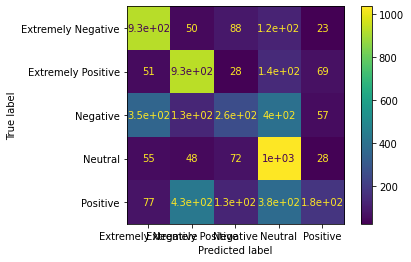

In [43]:
plot_confusion_matrix(model, X_test, y_test)

### Decision Tree Classifier


Fine-tuning hyperparameters with Grid Search takes a lot of time, so the default values of DecisionTreeClassifier were used.

In [44]:
# Find optimal parameters - very slow!
# model = Pipeline([
#     ('vectorizer', tfidf_vectorizer),
#     ('predictor', DecisionTreeClassifier())
# ])

# parameters = {
#     "predictor__criterion": ("gini", "entropy"),
#     "predictor__max_depth": range(1,10),
#     "predictor__min_samples_split": range(1,10),
#     "predictor__min_samples_leaf": range(1,5),
# }


# grid_search = GridSearchCV(model, parameters, cv=5, n_jobs=-1)
# grid_search = grid_search.fit(X_train, y_train)

# print("Grid Search Best Score: " + str(grid_search.best_score_))

# for param_name in sorted(parameters.keys()):
#     print("%s: %r" % (param_name, grid_search.best_params_[param_name]))
    
# Using optimal parameters
model = Pipeline([
    ('vectorizer', tfidf_vectorizer),
    ('predictor', DecisionTreeClassifier(class_weight="balanced"))
])

print_results(model)

                    precision    recall  f1-score   support

Extremely Negative       0.56      0.54      0.55      1211
Extremely Positive       0.54      0.50      0.52      1225
          Negative       0.35      0.34      0.34      1199
           Neutral       0.56      0.67      0.61      1239
          Positive       0.34      0.31      0.33      1192

          accuracy                           0.47      6066
         macro avg       0.47      0.47      0.47      6066
      weighted avg       0.47      0.47      0.47      6066



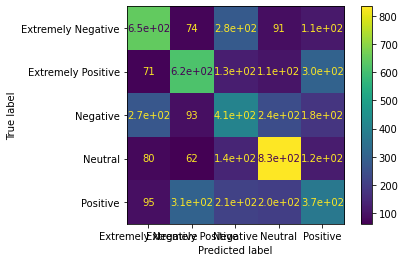

In [45]:
plot_confusion_matrix(model, X_test, y_test)

### Linear Support Vector Classifier (SVC)

In [46]:
# Find optimal parameters
model = Pipeline([
    ('vectorizer', tfidf_vectorizer),
    ('predictor', LinearSVC(max_iter=10000))
])

parameters = {
    "predictor__penalty": ("l1", "l2")
}


grid_search = GridSearchCV(model, parameters, cv=5, n_jobs=-1)
grid_search = grid_search.fit(X_train, y_train)

#print("Grid Search Best Score: " + str(grid_search.best_score_))

for param_name in sorted(parameters.keys()):
    print("%s: %r" % (param_name, grid_search.best_params_[param_name]))
    
# Using optimal parameters
model = Pipeline([
    ('vectorizer', tfidf_vectorizer),
    ('predictor', LinearSVC(penalty=grid_search.best_params_["predictor__penalty"],
                            class_weight="balanced", max_iter=10000))
])

print_results(model)

predictor__penalty: 'l2'
                    precision    recall  f1-score   support

Extremely Negative       0.67      0.77      0.72      1211
Extremely Positive       0.65      0.74      0.69      1225
          Negative       0.41      0.33      0.37      1199
           Neutral       0.62      0.70      0.66      1239
          Positive       0.41      0.32      0.36      1192

          accuracy                           0.57      6066
         macro avg       0.55      0.57      0.56      6066
      weighted avg       0.55      0.57      0.56      6066



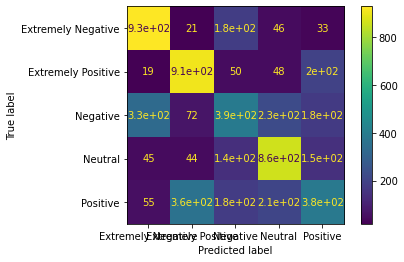

In [47]:
plot_confusion_matrix(model, X_test, y_test)

### Stochastic Gradient Descent (SGD) Classifier

In [48]:
# Find optimal parameters
model = Pipeline([
    ('vectorizer', tfidf_vectorizer),
    ('predictor', SGDClassifier())
])

parameters = {
    "predictor__alpha": (0.0001, 0.001, 0.01, 0.1, 1),
    "predictor__penalty": ("l1", "l2")
}

grid_search = GridSearchCV(model, parameters, cv=5, n_jobs=-1)
grid_search = grid_search.fit(X_train, y_train)

#print("Grid Search Best Score: " + str(grid_search.best_score_))

for param_name in sorted(parameters.keys()):
    print("%s: %r" % (param_name, grid_search.best_params_[param_name]))
    
# Using optimal parameters
model = Pipeline([
    ('vectorizer', tfidf_vectorizer),
    ('predictor', SGDClassifier(alpha=grid_search.best_params_["predictor__alpha"], 
                                penalty=grid_search.best_params_["predictor__penalty"],
                                class_weight="balanced"))
])

print_results(model)

predictor__alpha: 0.0001
predictor__penalty: 'l2'
                    precision    recall  f1-score   support

Extremely Negative       0.60      0.89      0.72      1211
Extremely Positive       0.57      0.88      0.69      1225
          Negative       0.48      0.16      0.24      1199
           Neutral       0.60      0.80      0.69      1239
          Positive       0.49      0.14      0.22      1192

          accuracy                           0.58      6066
         macro avg       0.55      0.57      0.51      6066
      weighted avg       0.55      0.58      0.51      6066



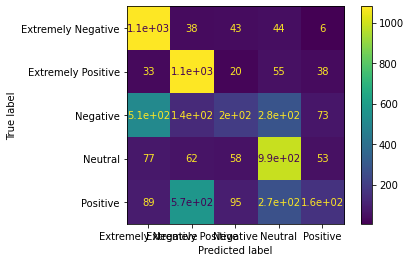

In [49]:
plot_confusion_matrix(model, X_test, y_test)

### Extreme Gradient Boosting Classifier (XGB)

Fine-tuning hyperparameters with Grid Search takes a lot of time, so custom values of XGBClassifier were used.

In [50]:
# # Find optimal parameters - very slow!
# model = Pipeline([
#     ('vectorizer', tfidf_vectorizer),
#     ('predictor', XGBClassifier())
# ])

# parameters = {
#     "predictor__learning_rate": (0.0001, 0.001, 0.01, 0.1),
#     "predictor__max_depth": (1,3,5,7),
#     "predictor__no_estimators": (5,10,100,500)
# }

# grid_search = GridSearchCV(model, parameters, cv=5, n_jobs=-1)
# grid_search = grid_search.fit(X_train, y_train)

# print("Grid Search Best Score: " + str(grid_search.best_score_))

# for param_name in sorted(parameters.keys()):
#     print("%s: %r" % (param_name, grid_search.best_params_[param_name]))
    
# Using optimal parameters
model = Pipeline([
    ('vectorizer', tfidf_vectorizer),
    ('predictor', XGBClassifier(learning_rate=0.1, max_depth=7, no_estimators=200,
                                colsample_bytree=0.8, subsample=0.8, nthread=10))
])

print_results(model)

                    precision    recall  f1-score   support

Extremely Negative       0.65      0.63      0.64      1211
Extremely Positive       0.64      0.66      0.65      1225
          Negative       0.41      0.29      0.34      1199
           Neutral       0.50      0.83      0.63      1239
          Positive       0.42      0.26      0.32      1192

          accuracy                           0.54      6066
         macro avg       0.52      0.53      0.52      6066
      weighted avg       0.53      0.54      0.52      6066



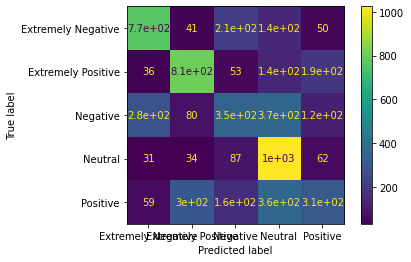

In [51]:
plot_confusion_matrix(model, X_test, y_test)

### Recurrent Neural Network (RNN)

In [52]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

vocab_size = len(tokenizer.word_index) + 1

X_train = pad_sequences(X_train, padding='post')
X_test = pad_sequences(X_test, padding='post')

encoding = {'Extremely Negative': 0,
            'Extremely Positive': 1,
            'Negative': 2,
            'Neutral': 3,
            'Positive': 4
           }
labels = ['Extremely Negative', 'Extremely Positive', 'Negative', 'Neutral', 'Positive']
y_train.replace(encoding, inplace=True)
y_test.replace(encoding, inplace=True)

embedding_dim = 16
hidden_dim = 256

def build_model(embedding_dim, hidden_dim):
  model = tf.keras.Sequential()
  model.add(L.Embedding(vocab_size, embedding_dim, input_length=X_train.shape[1]))
  model.add(L.Bidirectional(L.LSTM(hidden_dim,return_sequences=True)))
  model.add(L.GlobalMaxPool1D())
  model.add(L.Dropout(0.4))
  model.add(L.Dense(64, activation="relu"))
  model.add(L.Dropout(0.4))
  model.add(L.Dense(5, activation='softmax'))

  model.compile(loss=SparseCategoricalCrossentropy(from_logits=True), 
                optimizer='adam', metrics=['accuracy'])
  return model

tf.keras.backend.clear_session()
model = build_model(embedding_dim, hidden_dim)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 34, 16)            424368    
_________________________________________________________________
bidirectional (Bidirectional (None, 34, 512)           559104    
_________________________________________________________________
global_max_pooling1d (Global (None, 512)               0         
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                32832     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 3

In [53]:
epochs = 4
batch_size = 64
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.12)

Epoch 1/4
313/313 [==============================] - 14s 16ms/step - loss: 1.5432 - accuracy: 0.2769 - val_loss: 1.3157 - val_accuracy: 0.4890
Epoch 2/4
313/313 [==============================] - 4s 12ms/step - loss: 1.0977 - accuracy: 0.5771 - val_loss: 0.9479 - val_accuracy: 0.6385
Epoch 3/4
313/313 [==============================] - 4s 12ms/step - loss: 0.7221 - accuracy: 0.7421 - val_loss: 0.9505 - val_accuracy: 0.6440
Epoch 4/4
313/313 [==============================] - 4s 12ms/step - loss: 0.5681 - accuracy: 0.8041 - val_loss: 0.9564 - val_accuracy: 0.6454


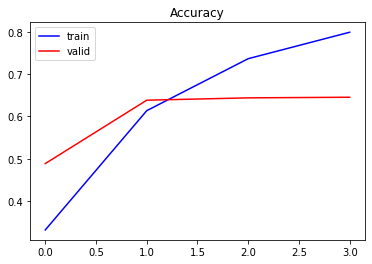

In [55]:
accuracy = history.history['accuracy']
valid_accuracy = history.history['val_accuracy']

epochs_range = range(epochs)

plt.plot(epochs_range, accuracy, color='blue', label='train')
plt.plot(epochs_range, valid_accuracy, color='red', label='valid')
plt.title("Accuracy")
plt.legend()
plt.show()

In [56]:
y_pred = np.argmax(model.predict(X_test), axis=-1)
print(classification_report(y_test, y_pred, target_names=labels))

                    precision    recall  f1-score   support

Extremely Negative       0.77      0.76      0.76      1509
Extremely Positive       0.72      0.79      0.75      1543
          Negative       0.51      0.57      0.54      1504
           Neutral       0.84      0.59      0.69      1540
          Positive       0.50      0.55      0.53      1487

          accuracy                           0.65      7583
         macro avg       0.67      0.65      0.66      7583
      weighted avg       0.67      0.65      0.66      7583



## Results

| Model                                        | Accuracy |
|----------------------------------------------|----------|
| Recurrent Neural Network (RNN)               | 0.65     |
| Logistic Regression                          | 0.59     |
| Stochastic Gradient Descent (SGD) Classifier | 0.58     |
| Linear Support Vector Classifier (SVC)       | 0.57     |
| Random Forest Classifier                     | 0.55     |
| Extreme Gradient Boosting Classifier (XGB)   | 0.54     |
| Multinomial Naive Bayes                      | 0.50     |
| Decision Tree Classifier                     | 0.47     |

